In [1]:
library(SingleCellExperiment)

library(kBET)
library(lisi)

library(ggplot2)
library(cowplot)
theme_set(theme_bw())

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges

In [2]:
source("../R/rvp.R")
# # source files
# src_files <- list.files('../../relapse_prediction/R', full.names = TRUE)
# for (f in src_files) {
#   source(f)
#   cat(sprintf('Sourced file: %s\n', f))
# }

# Villani

In [3]:
file <- "../data/villani/processed/villani.rds"
villani <- readRDS(file)

In [47]:
# assays(villani)
# colData(villani)
# rowData(villani)
# reducedDim(villani, "PCA")

In [4]:
batch_effects <- function(obj, batch, cls) {
  X <- assay(obj)
  metadata <- colData(obj)
  kbet_size <- dim(obj)[2]
  
  RVP <- rvp(obj, batch, cls)
  kbet_estimate <- kBET(
    Matrix::t(X),
    obj[[batch]],
    testSize = kbet_size, n_repeat = 1
  )
  rejection_rate <- kbet_estimate$summary$kBET.observed[1]
  lisi_results <- compute_lisi(
    Matrix::t(X),
    metadata,
    c(batch, cls)
  )
  print(head(lisi_results))
  blisi <- mean(lisi_results[[batch]])
  
  return(c(rvp = RVP, kbet = rejection_rate, lisi = blisi))
}

In [35]:
metrics <- batch_effects(villani, "batch", "celltype")

                 batch celltype
CD141_P10_S73 1.003938 1.053252
CD141_P10_S74 1.021713 2.287001
CD141_P10_S75 1.010505 1.077153
CD141_P10_S76 1.089969 1.246269
CD141_P10_S77 1.008777 1.223048
CD141_P10_S78 1.004377 2.294468


In [36]:
metrics

rvp       kbet       lisi 
0.08885395 0.65104167 1.05572753

In [5]:
RVP <- rvp(villani, "batch", "celltype")

In [14]:
SS <- rvp$sum_squares
# sort by ss_total
SS_t <- SS[order(-SS$ss_total), ]
# sort by ss_batch
SS_b <- SS[order(-SS$ss_batch), ]
# sort by mean
villani_counts <- assay(villani)
SS_m <- SS[order(-rowMeans(villani_counts)), ]
# sort by mean in top 10% cells
mean_counts_10 <- apply(villani_counts, 1, function(x) {
  pct <- 0.1
  mean(sort(x, decreasing = TRUE)[seq_len(pct * ncol(counts))])
})
SS_m10 <- SS[order(-mean_counts_10), ]

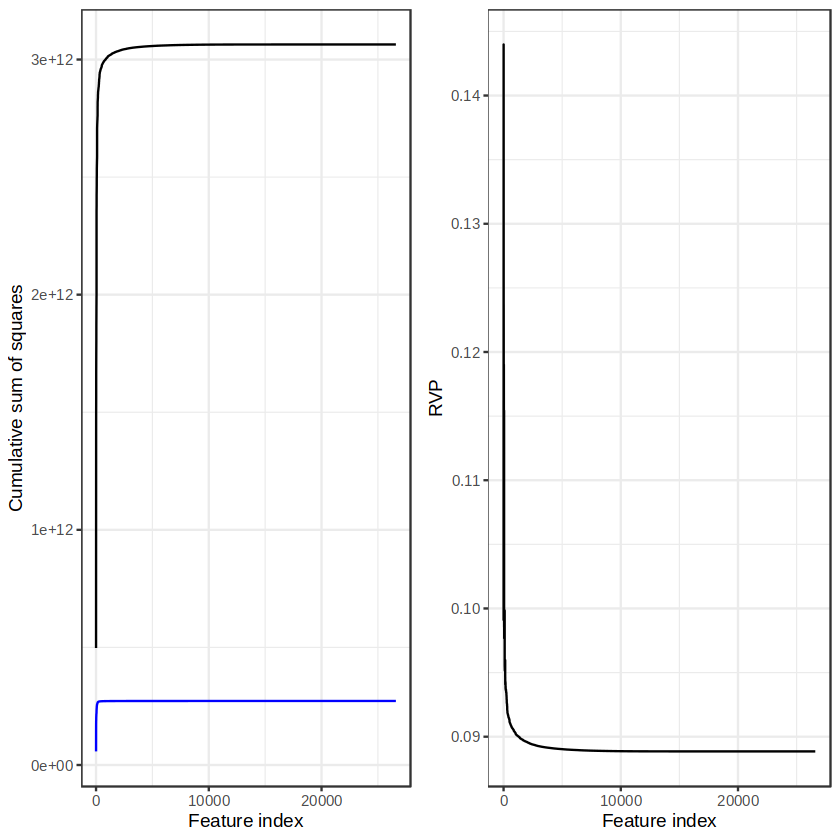

In [24]:
ax_rvp <- plot.rvp(SS_m10, cex = .5)
ax_rvp

file <- '~/Dropbox/tmp/ssm10-villani.pdf'
ggsave(file, ax_rvp, width = 6, height = 3)

#### Investigate

In [8]:
#' @param X Dataframe of dim (n_features, n_samples)
#' @param pct Minimum percentage of samples with value greater than zero
remove_features_dropout <- function(X, pct) X[rowSums(X > 0) >= pct * ncol(X), ]

#' @param X Dataframe of dim (n_features, n_samples)
#' @param pct Minimum percentage of samples with value greater than zero
remove_cells_lowcount <- function(X, pct) X[rowSums(X > 0) < pct * ncol]

[1] 16293   768

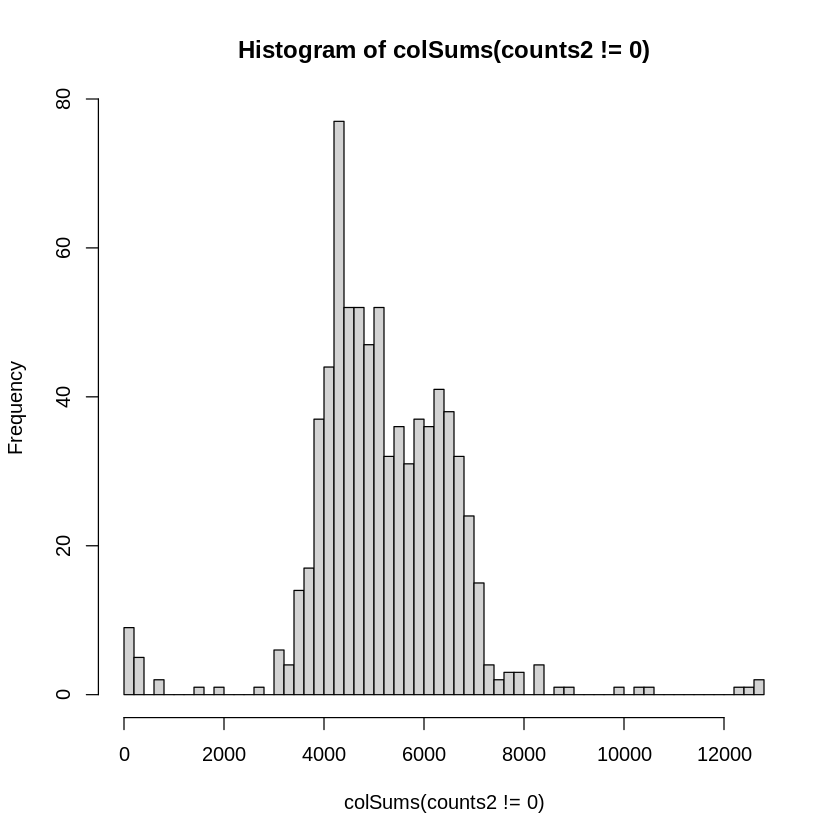

In [10]:
# filter features
counts2 <- remove_features_dropout(counts1, 0.01)
dim(counts2)

# filter doublets and empty cells
# low number of genes detected or low total counts
# filter cells with enriched mitochondrial rna
hist(colSums(counts2 != 0), breaks = 50)
# TODO: Inspect cells with detected < 2000

In [28]:
rvp1 <- RVP(t(counts1), coldata$batch, coldata$celltype, ret.obj = TRUE)
rvp2 <- RVP(t(counts2), coldata$batch, coldata$celltype, ret.obj = TRUE)

In [17]:
rvp <- RVP(t(counts2), coldata$batch, coldata$celltype, ret.obj = TRUE)
SS <- rvp$sum_squares

### Plots: PCA

In [28]:
coldata <- colData(villani)
ax_pca <- ggplot_pca(counts, coldata, col = 'batch', pch = 'cell_type1') +
  labs(subtitle = sprintf("RVP = %.4f", rvp$percentage))
ax_pca

ERROR: Error: subscript contains invalid names


In [55]:
file <- '~/Dropbox/tmp/pca-villani.pdf'
ggsave(file, ax2, width = 6, height = 4)